In [111]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW! for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_28985/2479774028.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [112]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

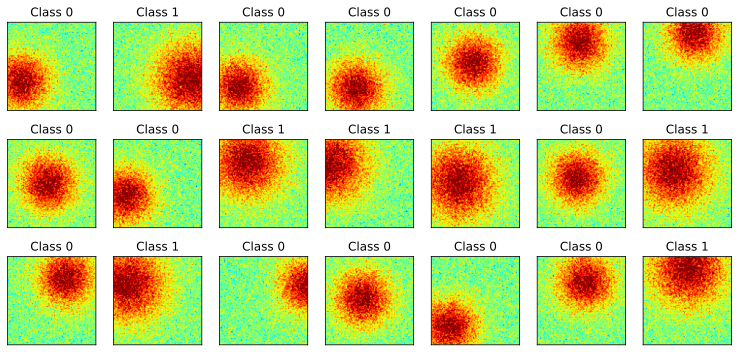

In [113]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [114]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [115]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # conv1
      self.conv1 = nn.Conv2d(1,6,3,padding=1)
      # output size: (91+2*1-3)/1 + 1 = 91
      # post-pooling: 91/2 = 45

      # conv2
      self.conv2 = nn.Conv2d(6,3,3,padding=1)
      # output size: (45+2*1-3)/1 + 1 = 45
      # post-pooling: 45/2 = 22

      # fc1
      self.fc1 = nn.Linear(22*22*3,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)
      
    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act,(2,2))
      
      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act,(2,2))

      # ANN part
      x = x.reshape(x.shape[0],-1)
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      
      return x,conv1act,conv2act
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [116]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

# test that the model runs and can compute a loss
X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X)
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 91, 91])

Feature map after conv2
torch.Size([32, 3, 45, 45])


In [117]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 3, 45, 45]             165
            Linear-3                   [-1, 50]          72,650
            Linear-4                    [-1, 1]              51
Total params: 72,926
Trainable params: 72,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.43
Params size (MB): 0.28
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


# Create a function that trains the model

In [118]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [98]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

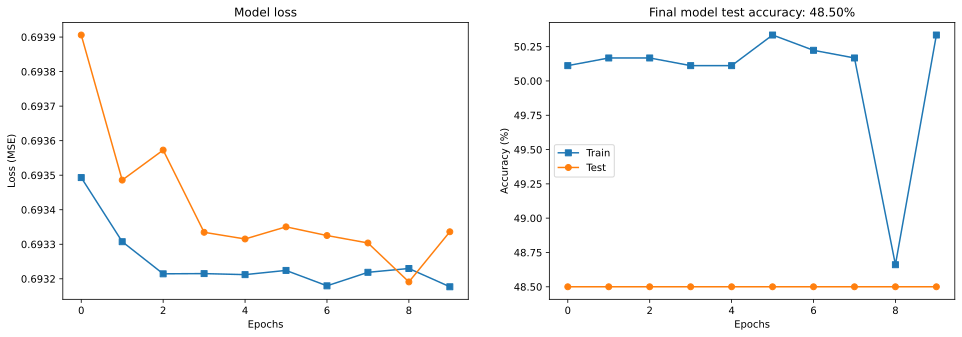

In [99]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

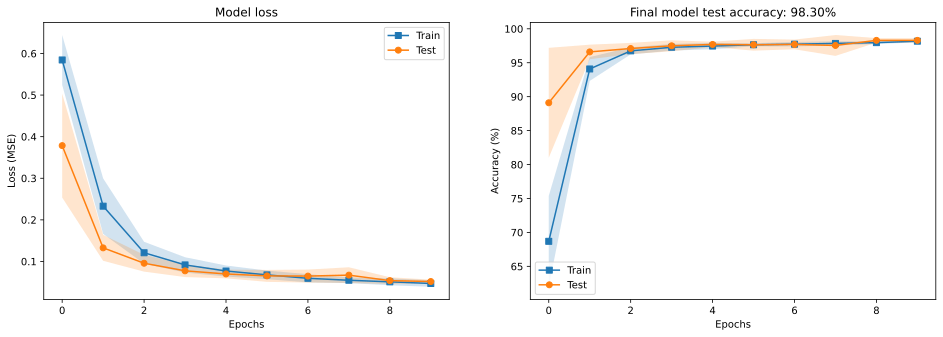

In [119]:
num_runs = 10  # Number of times to run the training function

trainLoss_list = []
testLoss_list = []
trainAcc_list = []
testAcc_list = []
net_list = []

for _ in range(num_runs):
    trainLoss, testLoss, trainAcc, testAcc, net = function2trainTheModel()
    trainLoss_list.append(trainLoss)
    testLoss_list.append(testLoss)
    trainAcc_list.append(trainAcc)
    testAcc_list.append(testAcc)
    net_list.append(net)

# Calculate the mean and standard deviation
trainLoss_mean = np.mean(trainLoss_list, axis=0)
testLoss_mean = np.mean(testLoss_list, axis=0)
trainAcc_mean = np.mean(trainAcc_list, axis=0)
testAcc_mean = np.mean(testAcc_list, axis=0)

trainLoss_std = np.std(trainLoss_list, axis=0)
testLoss_std = np.std(testLoss_list, axis=0)
trainAcc_std = np.std(trainAcc_list, axis=0)
testAcc_std = np.std(testAcc_list, axis=0)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss_mean, 's-', label='Train')
ax[0].plot(testLoss_mean, 'o-', label='Test')
ax[0].fill_between(range(len(trainLoss_mean)), trainLoss_mean - trainLoss_std, trainLoss_mean + trainLoss_std, alpha=0.2)
ax[0].fill_between(range(len(testLoss_mean)), testLoss_mean - testLoss_std, testLoss_mean + testLoss_std, alpha=0.2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc_mean, 's-', label='Train')
ax[1].plot(testAcc_mean, 'o-', label='Test')
ax[1].fill_between(range(len(trainAcc_mean)), trainAcc_mean - trainAcc_std, trainAcc_mean + trainAcc_std, alpha=0.2)
ax[1].fill_between(range(len(testAcc_mean)), testAcc_mean - testAcc_std, testAcc_mean + testAcc_std, alpha=0.2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc_mean[-1]:.2f}%')
ax[1].legend()

plt.show()

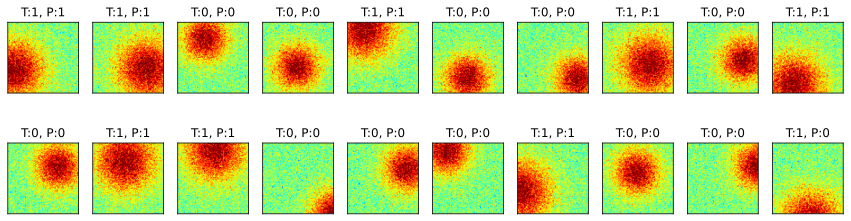

In [110]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Draw the feature maps

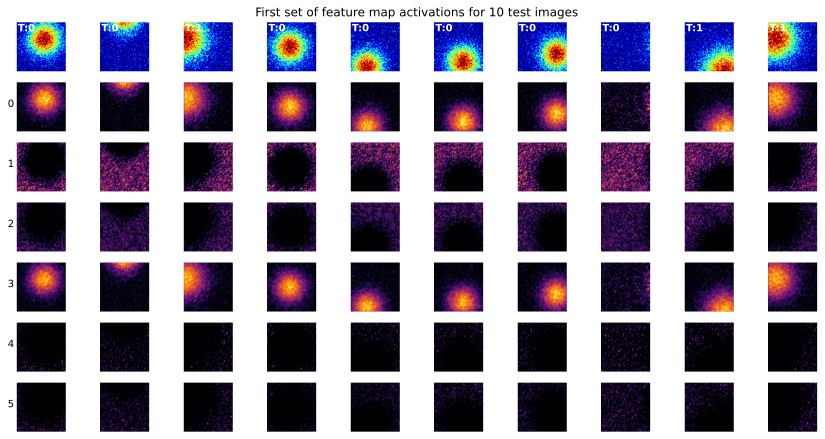

In [63]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(7,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(6):
    # extract the feature map from this image
    img = featmap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

- **Visualization of Feature Maps for Neural Network Analysis**: This code snippet is designed to showcase the activations within the second set of feature maps generated by a convolutional neural network (CNN) when applied to a subset of test images. This visualization technique is essential for understanding how different layers of a CNN respond to various aspects of input images, providing insights into the network's feature extraction process.

- **Displaying Original Images Alongside Feature Maps**: The first row of the plot is dedicated to displaying the original images from the test set. This provides a direct comparison point to the feature maps generated by the network, allowing for an assessment of what features might be highlighted or detected by the network at this stage.

- **Feature Map Extraction and Visualization**: For each of the 10 selected test images, the code extracts and displays the corresponding feature maps from the second convolutional layer of the model. These feature maps are visualized using a heatmap color scheme (`'inferno'`), with intensities scaled to highlight the distribution of activations across the map. This approach helps in identifying patterns, edges, or textures that the network may be focusing on within each image.

- **Enhanced Interpretability through Visualization**: By arranging the original images and their corresponding feature maps in a grid, the code facilitates a comprehensive overview of how the network processes and transforms visual information. The addition of labels for each feature map ensures clarity, and the use of color intensity to represent activation levels allows for an intuitive understanding of the network's behavior.

- **Insights into Deep Learning Model Functioning**: This visualization technique serves as a powerful tool for deep learning model interpretation, offering a window into the complex mechanisms of CNNs. By examining the feature maps generated in response to specific images, researchers and practitioners can gain valuable insights into the model's internal representations, potentially guiding improvements in model architecture or training strategies.

This markdown content explains the purpose and methodology behind visualizing the second set of feature maps generated by a convolutional neural network, emphasizing the significance of such visualizations in understanding and interpreting model behaviors.


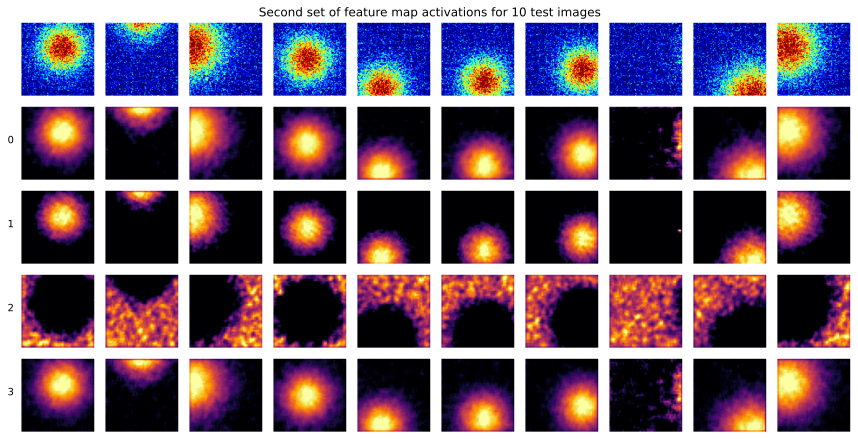

In [64]:
# Repeat for feature2 maps

fig,axs = plt.subplots(5,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(4):
    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

# Spatial correlations across the feature maps

- **Analyzing Feature Map Correlations**: This code segment focuses on examining the correlations between different feature maps produced by the second convolutional layer of a neural network. Such analysis is critical in understanding the diversity and redundancy of the representations learned by the network, offering insights into how various parts of the input data are processed and integrated.

- **Preparation and Correlation Calculation**:
  - The analysis starts by defining variables to hold the number of stimuli (`nStim`), the number of feature maps (`nMaps`), and the total number of unique feature map pairs (`nCors`).
  - A two-dimensional array `allrs` is initialized to store the correlation coefficients for each stimulus across all unique pairs of feature maps.
  - For each stimulus, the feature maps are vectorized and their correlations computed. The resulting correlation matrix `C` is then aggregated into `Call` to analyze across all stimuli.

- **Extraction and Visualization of Correlation Data**:
  - The correlations of interest are extracted from the upper triangular part of the correlation matrix, excluding the diagonal. This approach ensures that each pair is considered only once, avoiding redundancy.
  - The script generates two primary visualizations:
    1. **Scatter Plot of Correlation Coefficients**: For each pair of feature maps, the scatter plot displays individual correlation coefficients across all stimuli, with slight random horizontal jitter to improve visibility. This plot reveals the variability and distribution of correlations for each feature map pair.
    2. **Average Correlation Matrix**: The average correlation matrix across all stimuli is visualized as a heatmap, providing a comprehensive overview of how feature maps correlate with each other on average. High positive correlations indicate similar responses to the stimuli, while negative correlations suggest opposite responses.

- **Scientific Significance**:
  - Analyzing the correlations between feature maps can reveal the network's internal mechanisms and how it differentiates or assimilates information across its layers. High correlations might indicate redundancy in the learned features, while diverse correlations suggest a rich, varied representation of the input data.
  - Understanding these dynamics is essential for optimizing network architectures, interpreting their behavior, and identifying potential improvements in model design.

This markdown content encapsulates the process and scientific rationale behind analyzing correlations across feature maps in convolutional neural networks, emphasizing the implications for understanding and improving model performance.


In [65]:
featmap1.shape

torch.Size([200, 6, 91, 91])

In [66]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# nStim 200 nMaps 4 nCors 6

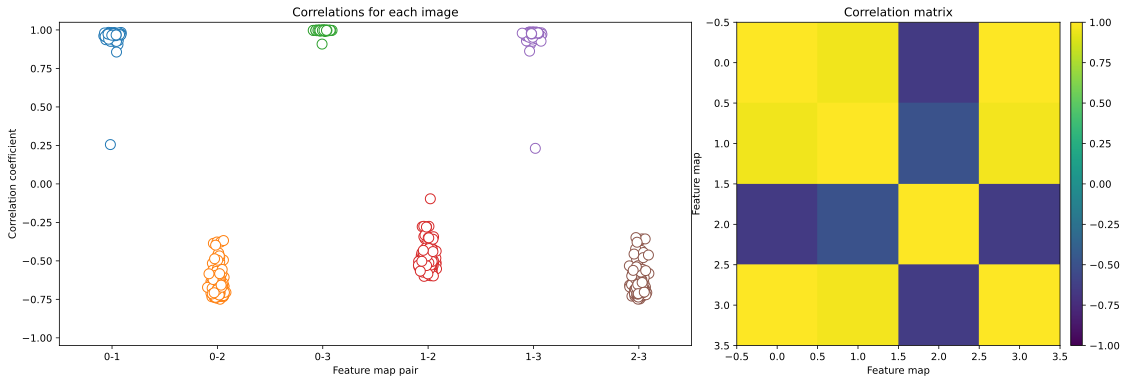

In [67]:
# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

This code analyzes the correlations between feature maps generated by the first convolutional layer of a neural network for a set of stimuli (images). By examining these correlations, insights into the diversity and redundancy of the features extracted by the layer can be gained. Here's a breakdown of the process and its scientific implications:

- **Setup and Preprocessing**: The code starts by defining variables to represent the number of stimuli (`nStim`), the number of feature maps (`nMaps`), and the number of unique correlation pairs (`nCors`). It initializes a matrix to hold the correlation values for each stimulus and an overall matrix (`Call`) to aggregate these correlations.

- **Correlation Computation**: For each stimulus, the corresponding set of feature maps is reshaped into a 2D format suitable for correlation analysis. The `numpy.corrcoef` function is then used to compute the correlation matrix for the feature maps, capturing the linear relationships between each pair of maps.

- **Aggregation and Visualization**: The correlations for each feature map pair are extracted from the upper triangle of the correlation matrix to avoid redundancy and are stored in an array. These correlations are then plotted to visualize the variation in relationships across stimuli. Additionally, the average correlation matrix across all stimuli is computed and visualized to provide a summary view of the inter-feature map relationships.

- **Interpretation and Analysis**: The scatter plot of individual correlations highlights the diversity in relationships between feature map pairs for different stimuli, potentially indicating the presence of specialized feature maps sensitive to specific patterns or textures. The average correlation matrix offers insights into the overall tendency of feature maps to exhibit similar or distinct activation patterns, reflecting on the network's ability to extract diverse features.

- **Scientific Implications**: Analyzing the correlations between feature maps is crucial for understanding the internal representations learned by convolutional neural networks. High correlations may suggest redundancy among feature maps, while low correlations indicate a more diverse set of features being captured. This analysis can guide modifications to the network architecture, such as reducing the number of filters in overly redundant layers, to improve efficiency without sacrificing performance.

By meticulously examining the correlations across the first convolutional layer's feature maps, this code segment sheds light on the complexity and efficiency of the feature extraction process within neural networks, offering valuable insights for optimizing model architectures.


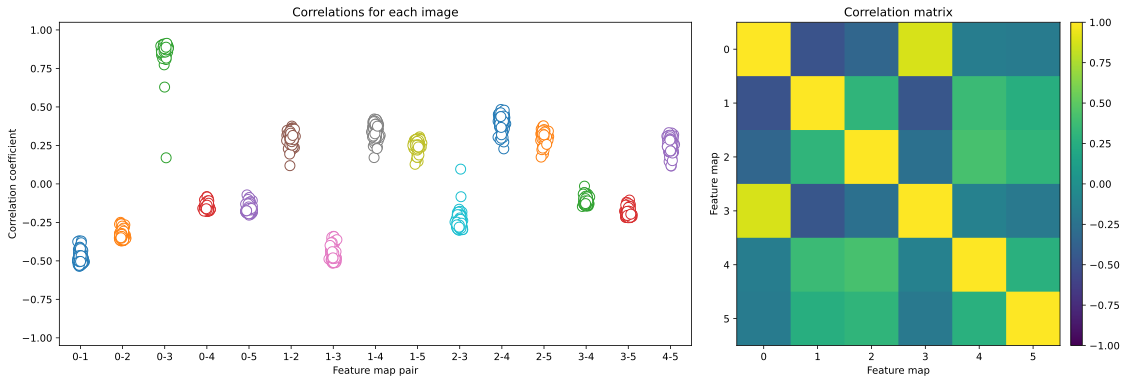

In [68]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

In [69]:
# Note: We will explore how to examine feature map activations without modifying the network class in the lecture
#       "Pretraining with autoencoders" in the Transfer Learning section.